**Автор - Федоров А. Н.**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from diffexpr.py_deseq import py_DESeq2
from matplotlib.lines import Line2D

# Задание 1. Определение дифференциальной экспрессии

Загрузим наши исходные данные:

In [2]:
df = pd.read_csv("01. RiboSeq_RNASeq_HCC_counts.tsv", sep="\t")
df.head()

,geneID,geneSymbol,LC001-normal-RPF,LC001-tumor-RPF,LC001-normal-RNA,LC001-tumor-RNA,LC033-normal-RPF,LC033-tumor-RPF,LC033-normal-RNA,LC033-tumor-RNA,...,LC507-normal-RNA,LC507-tumor-RNA,LC508-normal-RPF,LC508-tumor-RPF,LC508-normal-RNA,LC508-tumor-RNA,LC509-normal-RPF,LC509-tumor-RPF,LC509-normal-RNA,LC509-tumor-RNA
0,ENSG00000000003.14,TSPAN6,0,0,402,873,0,0,301,1627,...,218,457,0,0,200,889,0,0,161,857.0
1,ENSG00000000005.5,TNMD,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,NaN
2,ENSG00000000419.12,DPM1,168,239,88,187,114,439,66,201,...,92,170,109,357,60,244,141,173,56,83.0
3,ENSG00000000457.13,SCYL3,65,121,60,106,36,163,70,156,...,127,176,67,176,55,261,64,100,68,176.0
4,ENSG00000000460.16,C1orf112,8,43,18,70,16,76,4,63,...,124,437,7,167,34,201,6,61,9,58.0


Проверим на NA:

In [3]:
isna = df.isna().sum()
isna[isna > 0]

LC509-tumor-RNA    2688
dtype: int64

Не очень понятно, что в данном случае обозначает NA. Для простоты заполним 0:

In [4]:
df = df.fillna(0)

### Задание 1.1 - корреляция

Будем использовать корреляцию Спирмена, она покажет наличие любой монотонной (а не только линейной) зависимости.  

Чтобы учесть разную глубину библиотек, считать корреляцию будем поверх CPM(counts per million). В боевой задаче, конечно, нужно было бы подсчитать поверх нормализации из edgeR/DESeq или хотя бы поверх TPM. Но основная идея будет видна и при таком наивном подходе.

In [5]:
# CPM
samples = [x for x in df.columns if "LC" in x]
df[samples] /= df[samples].sum()
df[samples] *= 10**6

In [6]:
# Spearman
samples = sorted(set(x.rstrip("-RNA").rstrip("-RPF") for x in samples))

rnasamples = [f"{s}-RNA" for s in samples]
rna = df[rnasamples]
rna.columns = samples

rpfsamples = [f"{s}-RPF" for s in samples]
rpf = df[rpfsamples]
rpf.columns = samples

df["spearman-corr"] = rna.corrwith(rpf, axis=1, method="spearman")

### Задание 1.2 - гистограмма

Гистограмма:

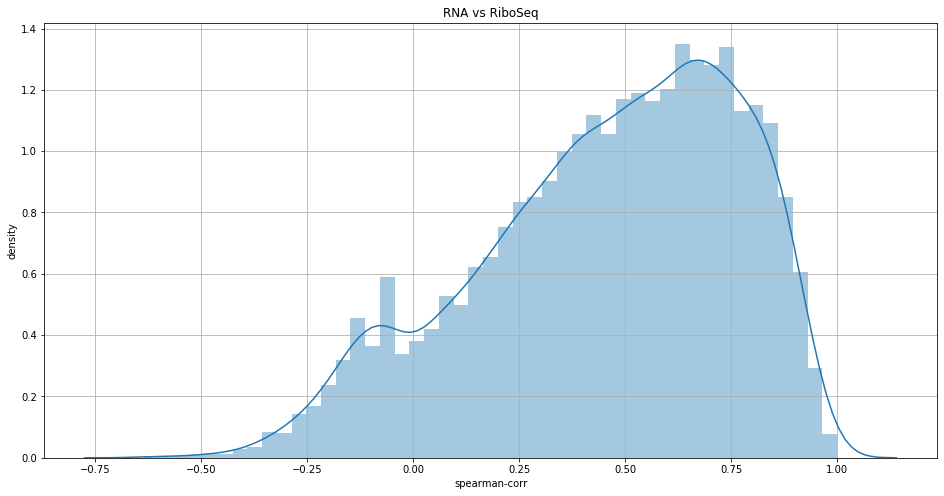

In [7]:
plt.figure(figsize=(16, 8))
plt.title("RNA vs RiboSeq")
sns.distplot(df["spearman-corr"])
plt.ylabel("density")
plt.grid()

Рассмотрим топ-5 по наивысшей и наименьшей корреляции. При этом отсечем гены с экспрессией близкой к 0(корреляция тривиальных 0 будет 1):

In [8]:
mask = (df[rnasamples].sum(axis=1) >= 10) & (df[rpfsamples].sum(axis=1) >= 10)
df[mask].nlargest(5, columns="spearman-corr")[["geneID", "geneSymbol", "spearman-corr"]]

,geneID,geneSymbol,spearman-corr
5495,ENSG00000124935.3,SCGB1D2,1.000000
18124,ENSG00000251258.1,RFPL4B,1.000000
9217,ENSG00000151715.7,TMEM45B,0.986466
11889,ENSG00000167910.3,CYP7A1,0.986466
15313,ENSG00000187048.12,CYP4A11,0.984962


Из gene-cards:  
* SCGB1D2 - chemotherapeutic agent used for prostate cancer
* RFPL4B - nothing
* TMEM45B - transmembrane protein
* CYP7A1 - ...synthesis of cholesterol, steroids and other lipids...
* CYP4A11 - ...synthesis of cholesterol, steroids and other lipids...

Пока ничего сильно значимого. Для лучшего понимания ситуации построим несколько зависимостей:

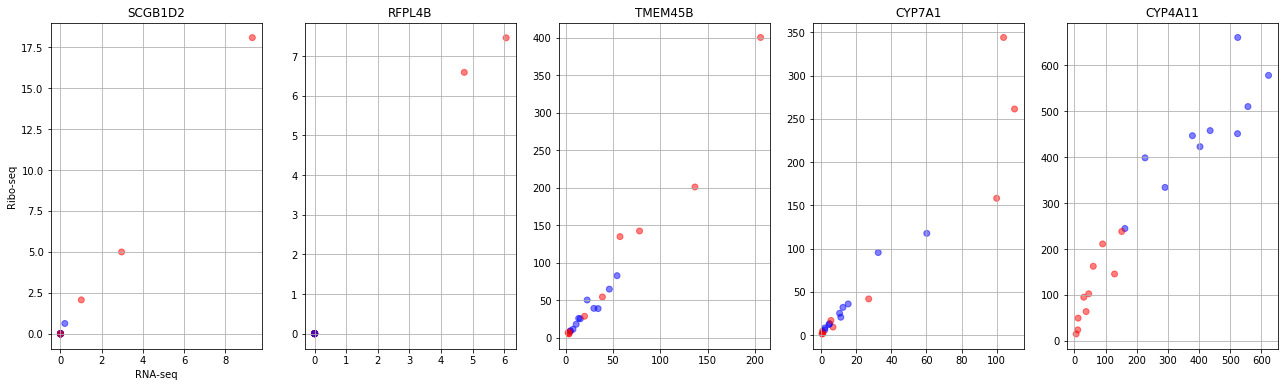

In [9]:
def plot_geneSymbols(symbols):
    color = ['red' if 'tumor' in x else 'blue' for x in rnasamples]
    fig, axes = plt.subplots(1, 5, figsize=(22, 6))
    for ax, symbol in zip(axes, symbols):
        counts = df[df["geneSymbol"] == symbol]
        rna, rpf = counts[rnasamples].values, counts[rpfsamples].values
        ax.scatter(rna, rpf, color=color, alpha=0.5)
        ax.set_title(symbol)
        ax.grid()
    axes[0].set_xlabel("RNA-seq")
    axes[0].set_ylabel("Ribo-seq")

plot_geneSymbols(["SCGB1D2", "RFPL4B", "TMEM45B", "CYP7A1", "CYP4A11"])

Видно, что гены с высокой корреляцией сильно меняют свой профиль экспресии в tumor/norm образцах. Говорить о том, какие конкретно это гены(домашнее хозяйство и т.д.) сложно, нужно делать ORA или GSEA по корреляции.

Посмотрим на гены с низкой корреляцией:

In [10]:
df.nsmallest(5, columns="spearman-corr")[["geneID", "geneSymbol", "spearman-corr"]]

,geneID,geneSymbol,spearman-corr
11882,ENSG00000167874.6,TMEM88,-0.634654
13994,ENSG00000179476.7,C14orf28,-0.629918
14062,ENSG00000179965.11,ZNF771,-0.617471
5618,ENSG00000125843.10,AP5S1,-0.612030
16627,ENSG00000203896.9,LIME1,-0.596992


Из gene-cards: 
* TMEM88 - transmembrane Protein
* C14orf28 - nothing
* ZNF771 - may be involved in transcriptional regulation/nothing
* AP5S1 - endosomal transport
* LIME1 - transmembrane adaptor

Интуитивных хитов опять нет, хотя и наш анализ не претендует на полноту. Посмотрим профили:

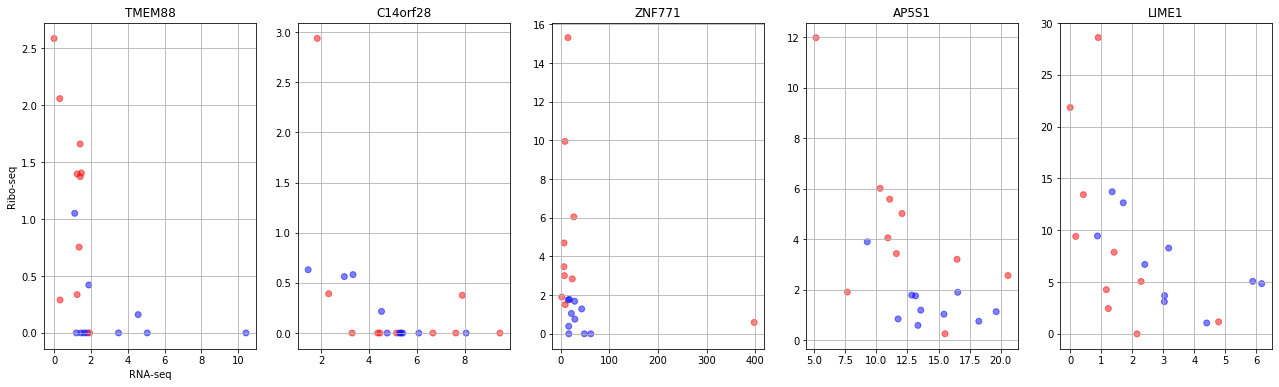

In [11]:
plot_geneSymbols(["TMEM88", "C14orf28", "ZNF771", "AP5S1", "LIME1"])

Сложная ситуация.   

Гены AP5S1 и LIME1 подходят под идею, описанную на лекции: в экспрессии может быть несколько мод и мы наблюдаем только одну + дисперсия.  

Для остальных генов +- верно, что мы наблюдаем очень небольшое число ribo-seq ридов и в разы больше ридов в rna-seq эксперименте (особенно в ZNF771). Две самые явные причины:  
* пост-трансляционная регуляция (mRNA есть, связывание с рибосомой заблокировано)  
* низкая эффективность трансляции (нужно много mRNA, чтобы поддерживать трансляцию на определенном уровне).

Опять же, мой анализ не претендует на полноту, по-хорошему надо удалить выбросы и нарисовать профиль хотя бы для 20-30 генов.

### Задание 1.3 - дифф. экспрессия

In [12]:
def diffexpr(columns):
    rows = df[columns]
    rows.columns = samples
    rows = rows.assign(geneID=df["geneID"])

    rows = py_DESeq2(count_matrix = rows,
                     design_matrix = design,
                     design_formula = '~ tissue',
                     gene_column = 'geneID')
    rows.run_deseq()
    rows.get_deseq_result(contrast = ['tissue','normal','tumor'])
    return rows.deseq_result

Будем считать, что батч-эффекта не существует и коррекцию/проверку делать нет нужды :)

In [13]:
df = pd.read_csv("01. RiboSeq_RNASeq_HCC_counts.tsv", sep="\t")
df = df.fillna(0)

Для вычисления дифф. экспресси воспользуемся DEseq(diffexpr). Построим design matrix:

In [14]:
tissue = [s.split("-")[1] for s in samples]
design = pd.DataFrame({"samples": samples, "tissue": tissue})
design.index = design.samples
design.head()

,samples,tissue
samples,,
LC001-normal,LC001-normal,normal
LC001-tumor,LC001-tumor,tumor
LC033-normal,LC033-normal,normal
LC033-tumor,LC033-tumor,tumor
LC034-normal,LC034-normal,normal


Дифф. экспрессия:

In [15]:
rnade = diffexpr(rnasamples)
rpfde = diffexpr(rpfsamples)








-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)



INFO:DESeq2:Using contrast: ['tissue', 'normal', 'tumor']






-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)



INFO:DESeq2:Using contrast: ['tissue', 'normal', 'tumor']


Volcano plot:  

In [18]:
# -log10(p-value)
rnade['-log10(p-value)'] = -np.log10(rnade.pvalue + 1e-64)
rpfde['-log10(p-value)'] = -np.log10(rpfde.pvalue + 1e-64)

In [19]:
# top-100 significant genes
qthreshold = 0.05
rpfde = rpfde.reindex_like(rnade)

rnasigthr = rnade["padj"].nsmallest(100)[-1]
assert rnasigthr < qthreshold
rnasig = rnade["padj"] < rnasigthr


rpfsigthr = rpfde["padj"].nsmallest(100)[-1]
rpfsig = rpfde["padj"] < rpfsigthr
assert rnasigthr < qthreshold

allsig = rnasig & rpfsig
rnasig = rnasig & (~allsig)
rpfsig = rpfsig & (~allsig)

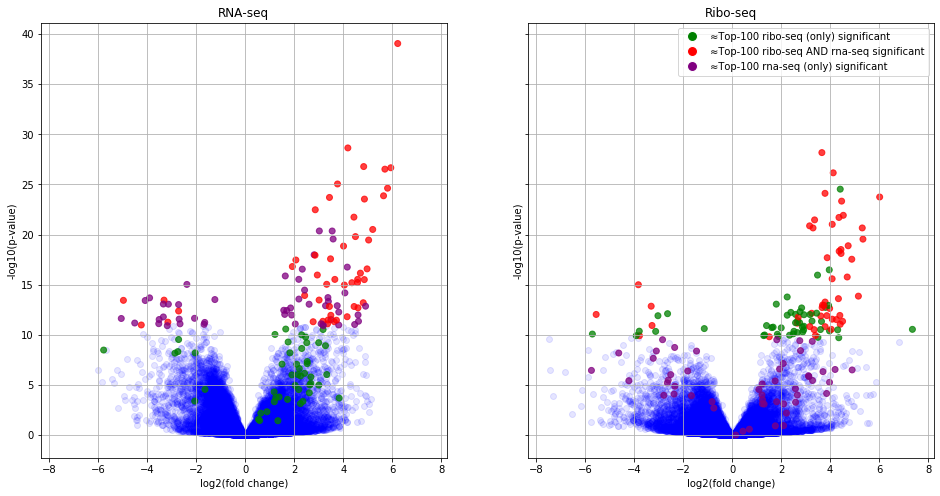

In [20]:
fig, (rnaax, rpfax) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

# red = signficant changes in both
# green = significant in ribo-seq
# purple = significant in rna-seq
# blue = else
colors = np.asarray(["blue" for _ in range(len(rpfde))], dtype="<U10")
colors[allsig] = "red"
colors[rnasig] = "purple"
colors[rpfsig] = "green"

# blot blue
mask = colors == "blue"
rnaax.scatter(rnade[mask]['log2FoldChange'], rnade[mask]['-log10(p-value)'], c='blue', alpha=0.1)
rpfax.scatter(rpfde[mask]['log2FoldChange'], rpfde[mask]['-log10(p-value)'], c='blue', alpha=0.1)

# signficant
mask = colors != "blue"
rnaax.scatter(rnade[mask]['log2FoldChange'], rnade[mask]['-log10(p-value)'], c=colors[mask], alpha=0.75)
rpfax.scatter(rpfde[mask]['log2FoldChange'], rpfde[mask]['-log10(p-value)'], c=colors[mask], alpha=0.75)


rnaax.set_title("RNA-seq")
rpfax.set_title("Ribo-seq")
for ax in (rnaax, rpfax):
    ax.grid()
    ax.set_ylabel("-log10(p-value)")
    ax.set_xlabel("log2(fold change)")
    

legend_elements = [
    Line2D([0], [0], markerfacecolor='green', markersize=10, marker='o', color='w', label='≈Top-100 ribo-seq (only) significant'),
    Line2D([0], [0], markerfacecolor='red', markersize=10, marker='o', color='w', label='≈Top-100 ribo-seq AND rna-seq significant'),
    Line2D([0], [0], markerfacecolor='purple', markersize=10, marker='o', color='w', label='≈Top-100 rna-seq (only) significant'),
]
rpfax.legend(handles=legend_elements)

Получился вполне симпатичный график, где отдельно выделены ~Top-100 самых значимых генов в каждом эксперименте + значимых в обоих. 

Численно посмотрим на долю совпадений для всех значимых дифф. экспрессируемых генов в 2 экспериментах:

In [21]:
qthreshold = 0.05

rnasig = rnade["padj"] < qthreshold
rpfsig = rpfde["padj"] < qthreshold

rnaseq_total = rnasig.sum()
riboseq_total = rpfsig.sum()
intersection = (rnasig & rpfsig).sum()

print("Всего значимых:")
print(f'\tRNA-seq:  {rnaseq_total}')
print(f'\tRibo-seq: {riboseq_total}')
print(f"Ribo-seq in RNA-seq: {(rnasig & rpfsig).sum() / rpfsig.sum(): .2f}%")
print(f"RNA-seq in ribo-seq: {(rnasig & rpfsig).sum() / rnasig.sum(): .2f}%")
print(f"IOU(intersection-over-union): {(rnasig & rpfsig).sum() / (rnasig | rpfsig).sum():.2f}")

Всего значимых:
	RNA-seq:  4812
	Ribo-seq: 2543
Ribo-seq in RNA-seq:  0.64%
RNA-seq in ribo-seq:  0.34%
IOU(intersection-over-union): 0.28


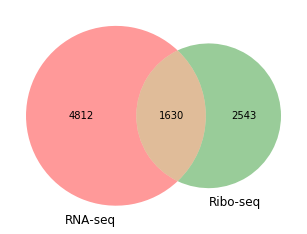

In [22]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
venn2(subsets = (rnaseq_total, riboseq_total, intersection), set_labels = ('RNA-seq', 'Ribo-seq'))

* Видно, что дифф. экспрессируемые гены между экспериментами совпадают довольно слабо, при этом в Ribo-seq их, в целом, меньше.  
* По volcano plot заметно, что гены значимые в одном эксперименте имеет значительно более низкий p-value в другом.    

Мы получили хоть и не слишком желательные результаты, но вполне объяснимые.  

Количество mRNA, количество рибосом на mRNA - это лишь прокси количества конкретного белка в клетке. Значимые изменения только по RNA-seq(только по Ribo-seq) часто могут говорить не о реальном изменении числа конкретных белков в клетке, а об изменении регуляции/эффективности транскрипции/трансляции и т.д.  

В тоже время одновременное значимое изменение в числе транскриптов и активных рибосом может иметь больший смысл, т.к. с большей вероятностью отражает реальное изменение концентрации какого-то белка.

**Вывод** - по возможности смотреть на пересечение значимых генов в ribo-seq и rna-seq. Держать в голове, что число транскриптов/рибосом не всегда = числу белков.

# Задание 2. Анализ wig-файла

Для начала считаем wig файлы. Т.к. геном у E.coli не большой, можно наивно перетащить все в dense numpy массив:

In [45]:
def parsewig(file, gsize=4641652):
    counts = np.zeros(gsize, dtype=np.uint32)
    with open(file, 'r') as file:
        file.readline() # discard header
        for line in file:
            pos, count = line.split()
            pos, count = int(pos), int(count)
            pos -= 1
            if pos >= counts.size:
                print(f"Out of the gsize: {pos}")
                continue
            pos -= 1  # looks like wig is 1 based
            assert counts[pos] == 0
            counts[pos] = count
    return counts

forward = parsewig("02. RiboSeq_EColi_track_f.wig")
reverse = parsewig("02. RiboSeq_EColi_track_r.wig")

Out of the gsize: 4641667


Очень странно, что есть позиции на ~20 нуклеотидов вне [ncbi референса](https://www.ncbi.nlm.nih.gov/nuccore/U00096).

### Задание 2.1 - неравномерность покрытия

Мы ожидаем, что покрытие в эксперименте будет неравномерным - рибосома сравнительно недолго нахотися в стадии транслокации. Мы должны часто видеть p-сайт в центре ожидаемых кодонов. 

Увидеть данный эффект на отдельных генах(например, в IGV) сложно - слишком маленькое покрытие. Поэтому будем рассматривать агрегированное покрытие для первых 100 нуклеотилов. 

Для того чтобы учесть разную глубину покрытия генов нормализуем каунты в первых 100 нуклеотидах на их сумму. Это довольно наивно, но картинка может получиться более адекватной

In [65]:
# parse gff3 labels
from BCBio import GFF

in_file = "sequence.gff3"

in_handle = open(in_file)
records = list(GFF.parse(in_handle, limit_info={"gff_type": ["CDS"]}))
in_handle.close()

assert len(records) == 1
record = records[0]

In [68]:
# aggregate counts and positional counts
features = [f for f in record.features if f.type == "CDS"]

gene_counts = {} # per gene
pos_counts = np.zeros(100, dtype=np.float32) # per position (triplets must be visible)
pos_counts_norm = np.zeros(100, dtype=np.float32) # per position (triplets must be visible)

for f in features:
    counts = forward if f.location.strand > 0 else reverse
    start, end = f.location.nofuzzy_start, f.location.nofuzzy_end # 0 based
    length = end - start
    assert length % 3 == 0

    gene_counts[f.id] = counts[start:end].sum()
    
    if length >= pos_counts.size:
        s, e = start, start + pos_counts.size
        pos_counts[:] += counts[s:e]
        pos_counts_norm[:] += counts[s:e] / (counts[s:e].sum() + 1e-3)

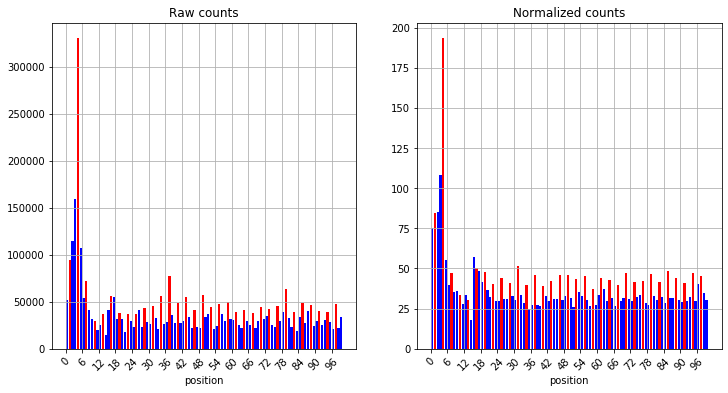

In [69]:
position = np.arange(pos_counts.size)
color = ['red' if x % 3 == 1 else 'blue' for x in position]

fig, (nonorm, norm) = plt.subplots(1, 2, figsize=(12, 6), sharex=True)
xticks = np.arange(pos_counts.size, step=6)

nonorm.bar(position + 0.5, pos_counts, color=color)
nonorm.grid()
nonorm.set_title("Raw counts")

norm.bar(position + 0.5, pos_counts_norm, color=color)
norm.grid()
norm.set_title("Normalized counts")

for ax in (nonorm, norm):
    ax.set_xlabel("position")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, rotation = 45)

Поведение на первых 20 нуклеотидах совсем не ожидаемое: самый большой пик должен быть на 1 кодоне, а не втором. Рибосома не должна задерживаться при старте трансляции, только из-за вторичных структур/недостатка аминокислот и прочего. Очень вероятно, что с координатами какая-то ерунда. 
1. Есть шанс, что мы используем не тот референс(почему в wig есть позиции вне референса?).
2. Есть шанс, что в добавок wig файл все же 0-based. В стандарте wig это не оговорено.
3. Мы упускаем что-то большое при нормализации/у нас черезчур маленькое покрытие - маловероятно.

Ожидаемо, после ~20 позиции видно, что рибосома действительно сравнительно недолго находится в стадии элонгации. Красные пики (p сайт по центру кодона) почти всегда выше синих. Хотя это и не настолько ярко выражено, как в слайдах презентации.

**Резюме** - получилась какая-то ерунда. Я несколько раз проверил, что работаю с указанным референсом, проверил код по подсчету каунтов.

### Задание 2.2 - RPKM и TPM

Формулы:  

$$RPKM_i = \frac{c_i}{\sum_j c_j * L_i} * 10^9$$

$$TPM_i = \frac{c_i}{L_i} * \frac{1}{\sum_j \frac{c_j}{L_j}} * 10^6$$

Здесть $c_i$ - риды, попавшие на $i$-ый ген, $L_i$ - длина этого гена.

В целом, эти меры используют для within sample нормализации (хотя TPM иногда и для same samples group). Они позволяют нам получить ответ на вопрос: во сколько раз транскриптов гена А больше чем гена Б в конкретном образце.  

Разница между ними видна по формулам. В RPKM мы нормализуем на размер библиотеки и на размер гена, а в TPM на размер гена и потом считаем l1 норму. Семантически более адекватно звучит TPM - количество транскриптов конкретного гена при секвенировании 1 млн. цельных(!) транскриптов.

Рассчеты:

In [71]:
RPKM, TPM = {}, {}

library_size = sum(gene_counts.values())
for f in features:
    start, end = f.location.nofuzzy_start, f.location.nofuzzy_end
    length = end - start
    assert length % 3 == 0
    
    RPKM[f.id] = gene_counts[f.id] * 10**9 / (library_size * length)
    TPM[f.id] = gene_counts[f.id] * 10**6 / length

norm = 1 / sum(TPM.values())
TPM = {k: v * norm for k, v in TPM.items()}

### Задание 2.3 - Оперон ATP

В gff3 разметке данный оперон явно не приведем, найдем его вручную:

In [72]:
atp = [f for f in features if "atp synthase" in f.qualifiers["product"][0].lower()]
for f in atp:
    print(f"id: {f.id}")
    print(f"\tloc:{f.location}")
    print(f"\tproduct: {f.qualifiers['product']}")

id: cds-AAC75008.1
	loc:[2016553:2017927](+)
	product: ['flagellum-specific ATP synthase FliI']
id: cds-AAC76754.1
	loc:[3915552:3915972](-)
	product: ['ATP synthase F1 complex subunit epsilon']
id: cds-AAC76755.1
	loc:[3915992:3917375](-)
	product: ['ATP synthase F1 complex subunit beta']
id: cds-AAC76756.1
	loc:[3917401:3918265](-)
	product: ['ATP synthase F1 complex subunit gamma']
id: cds-AAC76757.1
	loc:[3918315:3919857](-)
	product: ['ATP synthase F1 complex subunit alpha']
id: cds-AAC76758.1
	loc:[3919869:3920403](-)
	product: ['ATP synthase F1 complex subunit delta']
id: cds-AAC76759.1
	loc:[3920417:3920888](-)
	product: ['ATP synthase Fo complex subunit b']
id: cds-AAC76760.1
	loc:[3920949:3921189](-)
	product: ['ATP synthase Fo complex subunit c']
id: cds-AAC76761.1
	loc:[3921235:3922051](-)
	product: ['ATP synthase Fo complex subunit a']
id: cds-AAC76762.2
	loc:[3922059:3922440](-)
	product: ['ATP synthase accessory factor AtpI']


Скорее всего имеется ввиду оперон \[3915552, 3922440\) обратная цепочка - все CDS расположены очень близко друг к другу. 

Посмотрим на RPKM для CDSs данного оперона в Ribo-seq:

In [73]:
atp = atp[1:]
for gene in atp:
    print(f"{gene.qualifiers['product'][0]}")
    print(f"\tRPKM:{RPKM[gene.id]:.2f}")
    

ATP synthase F1 complex subunit epsilon
	RPKM:1141.26
ATP synthase F1 complex subunit beta
	RPKM:2526.82
ATP synthase F1 complex subunit gamma
	RPKM:604.88
ATP synthase F1 complex subunit alpha
	RPKM:1964.83
ATP synthase F1 complex subunit delta
	RPKM:725.73
ATP synthase Fo complex subunit b
	RPKM:1130.60
ATP synthase Fo complex subunit c
	RPKM:12346.85
ATP synthase Fo complex subunit a
	RPKM:1162.49
ATP synthase accessory factor AtpI
	RPKM:55.12


Видно, что разница есть. При этом данная разница вполне объяснима биологически.  

Например, субъединица F0 ATP синтетазы содержит 10-15 субъединиц **c** и 1 субъединицу **a**. 
Что чудесно, в эксперименте Ribo-seq соотношение рибосом в данных CDS $\frac{12346}{1162}=10.4$. 

Смогли бы мы увидеть такую картину по исключительно RNA-seq? Конечно, нет. RNA-seq у прокариот считает транскрипты, а весь оперон - это скорее всего один большой транскрипт.  
После нормализации на длину, число прочтений в каждом гене оперона было бы +- одинаково.

(Интересно, как работает регуляция в данном опероне. Все же это не довольно простой лактозный/триптофановый оперон + CDS расположены не по убыванию)